# Setup dirs

In [193]:
pwd

'/Users/ZhuJiaqi517/Documents/data/fish/valid'

In [190]:
cd /Users/ZhuJiaqi517/Documents/data/fish

/Users/ZhuJiaqi517/Documents/data/fish


In [11]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [191]:
cd train/

/Users/ZhuJiaqi517/Documents/data/fish/train


In [4]:
from shutil import copyfile
import os
from glob import glob
import numpy as np

In [37]:
g = glob('*')
for d in g: 
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [192]:
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(64): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(64): copyfile(shuf[i], '../sample/valid/' + shuf[i])

/Users/ZhuJiaqi517/Documents/data/fish/valid


In [41]:
%cd ..

/Users/ZhuJiaqi517/Documents/data/fish


In [42]:
%mkdir sample/results

# Get Data

In [15]:
cd ~/Documents/

/Users/ZhuJiaqi517/Documents


In [16]:
#path = "data/fish/"
path = "data/fish/sample/"
batch_size=16

In [17]:
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical

gen = image.ImageDataGenerator()

In [195]:
trn_batches = gen.flow_from_directory(path+'train', shuffle = False, batch_size = 1, target_size = (360,640), class_mode = 'categorical')

trn_classes = trn_batches.classes
trn_labels = to_categorical(trn_classes)
trn_filenames = trn_batches.filenames
trn = np.concatenate([trn_batches.next()[0] for i in range(trn_batches.nb_sample)])

Found 128 images belonging to 8 classes.


In [196]:
val_batches = gen.flow_from_directory(path+'valid', shuffle = False, batch_size = 1, target_size = (360,640), class_mode = 'categorical')

val_classes = val_batches.classes
val_labels = to_categorical(val_classes)
val_filenames = val_batches.filenames
val = np.concatenate([val_batches.next()[0] for i in range(val_batches.nb_sample)])

Found 119 images belonging to 8 classes.


In [52]:
test_batches = gen.flow_from_directory(path+'test', shuffle = False, batch_size = 1, target_size = (360,640), class_mode = 'categorical')

test_filenames = test_batches.filenames
test = np.concatenate([test_batches.next()[0] for i in range(test_batches.nb_sample)])

Found 10 images belonging to 1 classes.


In [197]:
trn.shape

(128, 3, 360, 640)

In [19]:
#move to utils
import bcolz

def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [198]:
save_array(path+'results/trn_640.dat', trn)
save_array(path+'results/val_640.dat', val)
save_array(path+'results/test_640.dat', test)

save_array(path+'results/trn_labels.dat', trn_labels)
save_array(path+'results/val_labels.dat', val_labels)

save_array(path+'results/trn_filenames.dat', trn_filenames)
save_array(path+'results/val_filenames.dat', val_filenames)
save_array(path+'results/test_filenames.dat', test_filenames)

In [20]:
trn = load_array(path+'results/trn_640.dat')
val = load_array(path+'results/val_640.dat')
test = load_array(path+'results/test_640.dat')

trn_labels = load_array(path+'results/trn_labels.dat')
val_labels = load_array(path+'results/val_labels.dat')

trn_filenames = load_array(path+'results/trn_filenames.dat')
val_filenames = load_array(path+'results/val_filenames.dat')
test_filenames = load_array(path+'results/test_filenames.dat')

# Basic Vgg16 with a Dense Top

In [3]:
import keras
from keras import backend as K

from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD, RMSprop, Adam
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.metrics import categorical_crossentropy, categorical_accuracy

from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.convolutional import *
# from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.utils.layer_utils import layer_from_config

from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer

Using Theano backend.


In [10]:
base_model = VGG16(weights='imagenet', include_top=True)
# pop the last layer and freeze all weights
base_model.layers.pop()
for layer in base_model.layers:
    layer.trainable = False

In [11]:
model = Sequential()
model.add(base_model)
model.add(Dense(8,activation='softmax'))

In [12]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [126]:
model.fit(trn, trn_labels, batch_size=batch_size, nb_epoch=3, validation_data=(val, val_labels))

Train on 64 samples, validate on 64 samples
Epoch 1/3
64/64 [==============================] - 46s - loss: 2.0661 - acc: 0.3281 - val_loss: 2.0464 - val_acc: 0.5312
Epoch 2/3
64/64 [==============================] - 45s - loss: 2.0358 - acc: 0.4844 - val_loss: 2.0332 - val_acc: 0.5625
Epoch 3/3
64/64 [==============================] - 47s - loss: 2.0168 - acc: 0.5625 - val_loss: 2.0189 - val_acc: 0.5156


In [127]:
model.save_weights(path+'results/ft1.h5')

In [13]:
model.load_weights(path+'results/ft1.h5')

# Pre-calculated Features

In [10]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(3,360,640))

In [11]:
#model = Model(input=base_model.input, output=base_model.get_layer('block5_conv3').output)
#model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 3, 360, 640)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, 360, 640)  1792        input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, 360, 640)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, 180, 320)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [12]:
model.output_shape

(None, 512, 22, 40)

In [21]:
trn_feat = base_model.predict(trn,verbose=1)
val_feat = base_model.predict(val,verbose=1)
test_feat = base_model.predict(test,verbose=1)

10/10 [==============================] - 15s


In [24]:
save_array(path+'results/trn_feat640.dat', trn_feat)
save_array(path+'results/val_feat640.dat', val_feat)
save_array(path+'results/test_feat640.dat', test_feat)

In [25]:
trn_feat = load_array(path+'results/trn_feat640.dat')
val_feat = load_array(path+'results/val_feat640.dat')
test_feat = load_array(path+'results/test_feat640.dat')

In [26]:
print('trn_feat shape: ' + str(trn_feat.shape))
print('output shape: ' + str(base_model.output_shape[1:]))

trn_feat shape: (128, 512, 11, 20)
output shape: (512, 11, 20)


In [204]:
def get_bn_layers(p):
    return [
        #use the shape for short
        #MaxPooling2D(input_shape=trn_feat.shape[1:]),
        BatchNormalization(axis=1,input_shape=trn_feat.shape[1:]),
        Dropout(p/4),
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p/2),
        Dense(8, activation='softmax')
    ]

In [205]:
p=0.6
bn_model = Sequential(get_bn_layers(p))
bn_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [206]:
bn_model.fit(trn_feat, trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=(val_feat, val_labels))

Train on 128 samples, validate on 119 samples
Epoch 1/3
128/128 [==============================] - 6s - loss: 2.4184 - acc: 0.2188 - val_loss: 10.3927 - val_acc: 0.2773
Epoch 2/3
128/128 [==============================] - 6s - loss: 1.5159 - acc: 0.5391 - val_loss: 8.7721 - val_acc: 0.3445

In [207]:
bn_model.optimizer.lr = 1e-4
bn_model.fit(trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(val_feat, val_labels))

Train on 128 samples, validate on 119 samples
Epoch 1/6
128/128 [==============================] - 6s - loss: 0.7749 - acc: 0.7969 - val_loss: 4.0636 - val_acc: 0.4958
Epoch 2/6
128/128 [==============================] - 6s - loss: 0.5929 - acc: 0.8203 - val_loss: 3.2673 - val_acc: 0.5546

In [208]:
bn_model.save_weights(path+'results/conv512_640.h5')

In [209]:
bn_model.load_weights(path+'results/conv512_640.h5')

# Multi-Input

In [252]:
import PIL
from PIL import Image
sizes = [PIL.Image.open(path+'train/'+f).size for f in trn_filenames]
vs = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
sizes+=vs
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [253]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 16,
         (1276, 718): 14,
         (1280, 720): 134,
         (1280, 750): 40,
         (1280, 924): 5,
         (1280, 974): 34,
         (1334, 750): 1,
         (1518, 854): 1,
         (1732, 974): 2})

In [254]:
#sizes = [PIL.Image.open(path+'train/'+f).size for f in trn_filenames]
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))

In [255]:
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))

In [256]:
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

In [265]:
#trn_sizes = np.nan_to_num(trn_sizes)
#val_sizes = np.nan_to_num(val_sizes)

In [272]:
inp = Input(trn_feat.shape[1:])
sz_inp = Input((len(id2size),))
bn_inp = BatchNormalization()(sz_inp)

x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)
x = merge([x,bn_inp], 'concat')
x = Dense(8, activation='softmax')(x)

In [273]:
model = Model([inp, sz_inp], x)
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [274]:
model.fit([trn_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=3, 
             validation_data=([val_feat, val_sizes], val_labels))

Train on 128 samples, validate on 119 samples
Epoch 1/3
128/128 [==============================] - 1s - loss: 2.5489 - acc: 0.1953 - val_loss: 8.4881 - val_acc: 0.3361
Epoch 2/3
128/128 [==============================] - 1s - loss: 1.3874 - acc: 0.5859 - val_loss: 6.8954 - val_acc: 0.4118

In [275]:
bn_model.optimizer.lr = 1e-4
model.fit([trn_feat, trn_sizes], trn_labels, batch_size=batch_size, nb_epoch=8, 
             validation_data=([val_feat, val_sizes], val_labels))

Train on 128 samples, validate on 119 samples
Epoch 1/8
128/128 [==============================] - 1s - loss: 0.5831 - acc: 0.8281 - val_loss: 4.7338 - val_acc: 0.3782
Epoch 2/8
128/128 [==============================] - 1s - loss: 0.6011 - acc: 0.8125 - val_loss: 3.8508 - val_acc: 0.4538

# Fully convolutional net (FCN)

In [276]:
nf=128; p=0.0

In [277]:
# remove maxpooling for better resolution, can add dropout if result is not good
def get_lrg_layers():
    return [
        BatchNormalization(axis=1, input_shape=trn_feat.shape[1:]),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(axis=1),
        Convolution2D(8,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]

In [278]:
lrg_model = Sequential(get_lrg_layers())

In [279]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
lrg_model.fit(trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(val_feat, val_labels))

Train on 128 samples, validate on 119 samples
Epoch 1/2
128/128 [==============================] - 3s - loss: 1.9385 - acc: 0.2812 - val_loss: 4.3922 - val_acc: 0.3529
Epoch 2/2
128/128 [==============================] - 3s - loss: 1.0470 - acc: 0.6641 - val_loss: 4.8308 - val_acc: 0.3613

In [280]:
lrg_model.optimizer.lr=1e-5
lrg_model.fit(trn_feat, trn_labels, batch_size=batch_size, nb_epoch=6, 
             validation_data=(val_feat, val_labels))

Train on 128 samples, validate on 119 samples
Epoch 1/6
128/128 [==============================] - 3s - loss: 0.5774 - acc: 0.8594 - val_loss: 4.6298 - val_acc: 0.5462
Epoch 2/6
128/128 [==============================] - 3s - loss: 0.3166 - acc: 0.9297 - val_loss: 4.6943 - val_acc: 0.4454

In [281]:
lrg_model.save_weights(path+'results/fcn640.h5')
lrg_model.load_weights(path+'results/fcn640.h5')

In [282]:
lrg_model.evaluate(val_feat, val_labels)

119/119 [==============================] - 0s     


[3.2381456519375327, 0.59663865471086586]

## plot result

In [304]:
l = lrg_model.layers
conv_fn = K.function([l[0].input, K.learning_phase()], l[-3].output)    #conv_fn need a learning phase 0 for test 1 for train

inp = np.expand_dims(val_feat[-4], 0)   # so the still be a 4-d tensor
np.round(lrg_model.predict(inp)[0],2)   #get the predict for 1 class

array([ 0.01      ,  0.09      ,  0.15000001,  0.15000001,  0.        ,
        0.        ,  0.07      ,  0.50999999], dtype=float32)

In [308]:
import scipy
def get_cm(inp, label):
    inp = np.expand_dims(inp, 0)
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (360,640))

In [285]:
from matplotlib import pyplot as plt
%matplotlib inline 

# move to utils
def to_plot(img):
    return np.rollaxis(img, 0, 3).astype(np.uint8)    #convert image input to a normal shape, we have (chanel, rows, cols) now

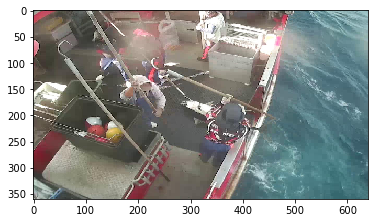

In [305]:
plt.imshow(to_plot(val[-4]))

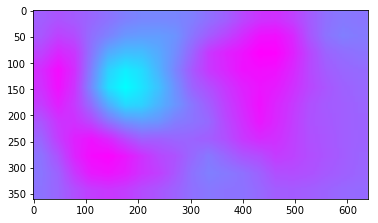

In [310]:
cm = get_cm(val_feat[-4], 7)
plt.imshow(cm, cmap="cool")

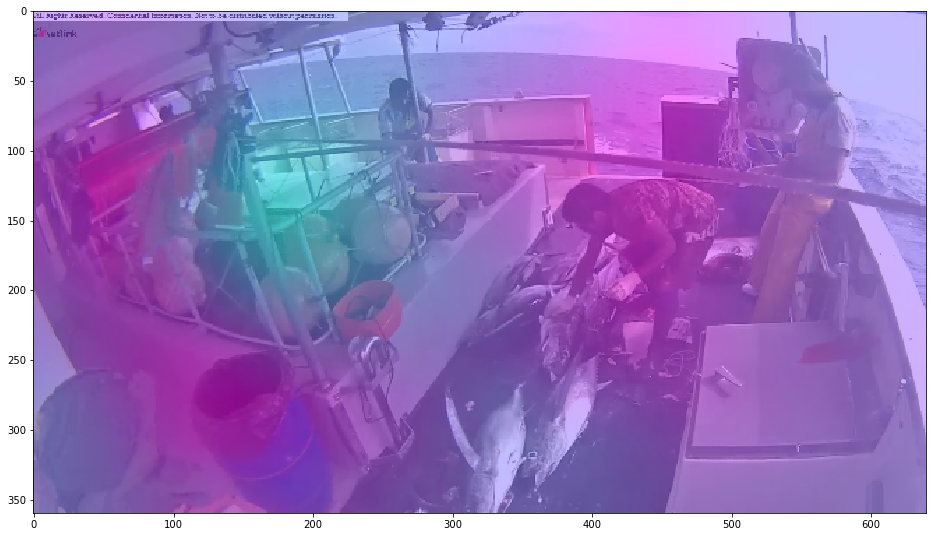

In [311]:
plt.figure(figsize=(16,16))
plt.imshow(to_plot(val[0]))
plt.imshow(cm, cmap="cool", alpha=0.5)

# Inception Block

In [27]:
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization(axis=1)(x)

In [28]:
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=1)

In [29]:
inp = Input(trn_feat.shape[1:]) 
x = BatchNormalization(axis=1)(inp)
x = incep_block(x)
x = incep_block(x)
x = incep_block(x)
x = Dropout(0.75)(x)
x = Convolution2D(8,3,3, border_mode='same')(x)
x = GlobalAveragePooling2D()(x)
outp = Activation('softmax')(x)

In [30]:
lrg_model = Model([inp], outp)

In [32]:
lrg_model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
lrg_model.fit(trn_feat, trn_labels, batch_size=batch_size, nb_epoch=2, 
             validation_data=(val_feat, val_labels))